# Procesamiento de señales de velocidad obtenidas a partir de un ADV

El presente es un documento interactivo con análisis básicos aplicados a señales de flujos turbulentos obtenidas a través de un ADV Sontek 16MHz. Las indicaciones se basaron principalmente en el trabajo *GUÍA PRÁCTICA PARA REALIZAR MEDICIONES DE VELOCIDAD EN FLUJOS TURBULENTOS CON ADV. Versión 2016* (García, et al. 2016).

Los procedimientos presentados deben aplicarse a un archivo _*Vf_ producido por el software _WinADV_. Se requiere que la señal a analizar sea procesada para eliminar los valores anómalos (*spikes*) previamente, con un filtro como el *Phase-space Threshold* (Goring y Nikora, 2002). En la elaboración del documento se consideró que los valores anómalos descartados fueron reemplazados con el indicador "-99". 

## Importar librerías

In [258]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import random
import time
from statsmodels.tsa.stattools import acf
import ipywidgets as widgets

## Cargar series

Importación de los archivos de extensión _*.Vf_, producidos por el software *WinADV*. Se considera que el encabezado está compuesto por 9 líneas y que se utiliza punto y coma (;) para delimitar las columnas.

In [307]:
path = 'E:\\PROYECTOS\\ADV\\ADV-Notebooks\\python_script'
file = '20181227_0010.Vf'
data = np.genfromtxt(path+'\\'+file, delimiter=";", skip_header=9)

Reemplazo del indicador de valores anómalos reemplazados (-99) por NaNs.

In [308]:
data[data==-99]=np.nan

Extracción de series de tiempo y velocidades medidas en las tres dimensiones ($Vx_{raw}$, $Vy_{raw}$,$Vz_{raw}$).

In [309]:
# Serie de tiempo
time  = np.copy(data[:,0])

# Velocidades
Vx_raw = np.copy(data[:,3])
Vy_raw = np.copy(data[:,4])
Vz_raw = np.copy(data[:,5])

# Correlación media para todos los beams
Cor_med = np.copy(data[:,15])

# Señal ruido (SNR) media para todos los beams
SNR_med = np.copy(data[:,16])

Definición de la frecuencia de muestreo $fs$.

In [310]:
fs = 1//(time[1]-time[0])

## Calidad de la señal

### Señal ruido (SNR)

La $SNR$ relaciona la amplitud de la señal acústica recibida y el ruido ambiente. Es un indicador de la cantidad de partículas presentes en el agua (sedimentos, organismos pequeños, burbujas) que reflejarán los pulsos acústicos. **Valores menores a 15 db indicarían la presencia de pocas particulas, y la necesidad de adicionarlas.** (García, et al.2016)

In [311]:
display('SNR media (dB): '+ str(np.nanmean(SNR_med)))
display('SNR varianza (dB^2): '+ str(np.nanvar(SNR_med)))

'SNR media (dB): 25.663775544165606'

'SNR varianza (dB^2): 11.946137033291281'

### Correlación

**Generalmente, se requiere un parámetro de correlación mayor al 70% para obtener una buena representación del flujo.** (García )

In [312]:
display('Correlación media (%): '+ str(np.nanmean(Cor_med)))
display('Correlación varianza (%): '+ str(np.nanvar(Cor_med)))

'Correlación media (%): 97.68941622844972'

'Correlación varianza (%): 1.1388735392613663'

### Cantidad de valores anómalos filtrados

Las señales de velocidad del flujo pueden presentar en algunos casos, valores extremos anómalos (denominados “spikes” en inglés), originados por distintas razones como por ejemplo la presencia de velocidades de flujo que exceden al rango de velocidad seleccionado en la configuración del instrumento, por contaminación de pulsos previos reflejados desde contornos de geometrías complejas, por falta de partículas trazadoras en el agua, cuando los niveles de turbulencia son muy elevados, etc. Estos valores anómalos presentes en la señal generan errores (sesgo) en la determinación de los parámetros de la turbulencia que se estiman sobre la base de estas series (García et al. 2016).
La técnica de detección empleada más extensivamente es la denominada *Phase Space Threshold* (Goring y Nikora, 2002).

In [313]:
display('Valores filtrados Vx (%): '+str(100*np.count_nonzero(np.isnan(Vx_raw))/len(Vx_raw)))
display('Valores filtrados Vy (%): '+str(100*np.count_nonzero(np.isnan(Vy_raw))/len(Vy_raw)))
display('Valores filtrados Vz (%): '+str(100*np.count_nonzero(np.isnan(Vz_raw))/len(Vz_raw)))

'Valores filtrados Vx (%): 3.392173885084081'

'Valores filtrados Vy (%): 3.392173885084081'

'Valores filtrados Vz (%): 3.392173885084081'

## Reemplazo de valores anómalos filtrados

El reemplazo del valor anómalo detectado no es requerido para el cálculo de los momentos estadísticos pero es esencial para los cálculos de todos los parámetros de la turbulencia derivados a partir del espectro de energía y de las funciones de autocorrelación. Entre las técnicas de reemplazo de valores anómalos más utilizados se pueden mencionar al reemplazo con el último valor correcto registrado previamente, al reemplazo con el valor interpolado a partir del ajuste a un polinomio de tercer grado utilizando 12 puntos válidos a cada lado del dato anómalo (24 datos en total, Goring and Nikora 2002) y el reemplazo por una simple interpolación lineal entre los datos válidos registrados antes y después del valor anómalo.

En el siguiente caso se empleará una interpolación lineal para el reemplazo de los puntos eliminados.

In [314]:
# Definición de la función de reemplazo 'lininterp'
def lininterp(a):
    b = np.copy(a)
    ok = ~np.isnan(b)
    xp = ok.ravel().nonzero()[0]
    fp = b[~np.isnan(b)]
    x  = np.isnan(b).ravel().nonzero()[0]
    b[np.isnan(b)] = np.interp(x, xp, fp)
    return b

In [315]:
# Velocidades con valores filtrados reemplazados
Vx_int = lininterp(Vx_raw)
Vy_int = lininterp(Vy_raw)
Vz_int = lininterp(Vz_raw)

## Extracción del ruido Doppler

Nikora and Goring (1998) señalaron que la principal fuente de ruido en las mediciones que se realizan con velocímetros acústico doppler es el ruido Doppler. García et al. (2005) analizaron la importancia relativa de la energía del ruido Doppler con respecto al total de la energía turbulenta capturada con los ADV, señalando que cuando el impacto del ruido es alto se
requieren correcciones a los parámetros de la turbulencia que se estimen. El ruido Doppler tiene las características del ruido blanco (Nikora and Goring 1998; Lemming and Lhermitte 1999; Mc Lelland and Nicholas 2000) con una distribución de probabilidad
Gaussiana, esto es media cero y varianza finita (Nikora and Goring 1998), así como también un espectro de potencia plano (Anderson and Lohrmann 1995), es decir afecta de igual modo a todas las componentes de frecuencias de la señal ( espectro de potencia constante sobre el rango de frecuencias muestreadas) lo cual indica la presencia de ruido sin correlación. La presencia de ruido blanco en las señales de velocidad medidas con ADV no afecta el cálculo de los valores medios (Nikora and Goring, 1998; Voulgaris and Trowbridge 1998) ni el de las Tensiones de Reynolds (McLelland and Nicholas, 2000), mientras que las estimaciones de la energía cinética turbulenta se encuentra sesgada hacia valores más altos (Nikora and Goring 1998). Puesto que el ruido blanco produce falta de correlación en la señal la función de autocorrelación reduce su valor a cero más rápido que cuando se verifica presencia de ruido, al tiempo que el espectro de potencia resulta sesgado a valores altos (Lohrmann et al. 1994; Nikora and Goring 1998).

Para señales de relativa baja energía, el ruido blanco puede detectarse como un aplanamiento del espectro próximo a la frecuencia de Nyquist (*fs/2*) (García 2005). En esos casos Nikora and Goring (1998) sugieren que el espectro de dicho ruido se puede representar por una línea horizontal recta cuyas ordenadas son igual al promedio de las ordenadas espectrales del ruido. Esta técnica fue llamada “Análisis espectral” por Voulgaris and Trowbridge (1998), quienes proponen calcular la energía asociada al ruido a partir del nivel de energía detectado en la cola del espectro, en un rango de frecuencias tal que garantice 10 estimaciones para el cálculo del promedio estadístico.

### Determinación del nivel de ruido

A continuación se aplica el "Análisis espectral" (Voulgaris and Trowbridge, 1998) para la extracción del ruido Doppler del espectro de energía de la señal de velocidad. Se adopta el rango $[fs/2-1Hz,fs/2]$ para el cálculo del nivel de energía del ruido. **Debe verificarse visualmente que dicho nivel se corresponda con un aplanamiento en el espectro de la señal no filtrada, y que el rango contenga por lo menos 10 valores.**

In [316]:
def noise (a,nfft):
    (psd, freq)=mlab.psd(a-np.mean(a), detrend=mlab.detrend_none, noverlap=nfft//2, NFFT=nfft, Fs=fs,window=np.hamming(nfft),pad_to=nfft,sides='onesided',scale_by_freq=True)
    dopplernoise = np.mean(psd[len([f for f in freq if f <= 0.5*fs-1]):])
    display('Cantidad de valores en el rango [fs/2-1Hz, fs/2]: '+str(len([f for f in freq if f <= 0.5*fs-1])))
    return psd, freq, dopplernoise

In [317]:
psdx_unf,fx,noisex = noise(Vx_int,1024)
psdy_unf,fy,noisey = noise(Vy_int,1024)
psdz_unf,fz,noisez = noise(Vz_int,1024)

display('Ruido Doppler, componente x (cm2/s): ' + str(noisex))
display('Ruido Doppler, componente y (cm2/s): ' + str(noisey))
display('Ruido Doppler, componente z (cm2/s): ' + str(noisez))

'Cantidad de valores en el rango [fs/2-1Hz, fs/2]: 492'

'Cantidad de valores en el rango [fs/2-1Hz, fs/2]: 492'

'Cantidad de valores en el rango [fs/2-1Hz, fs/2]: 492'

'Ruido Doppler, componente x (cm2/s): 0.004221079206925499'

'Ruido Doppler, componente y (cm2/s): 0.004464462136445076'

'Ruido Doppler, componente z (cm2/s): 0.0001478850653984826'

### Verificación del nivel de ruido

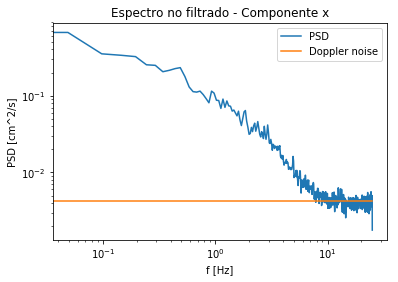

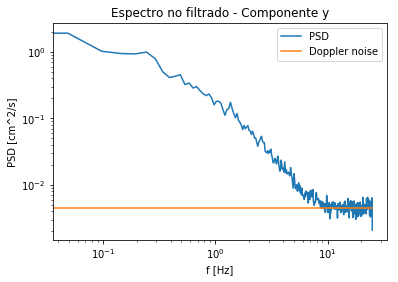

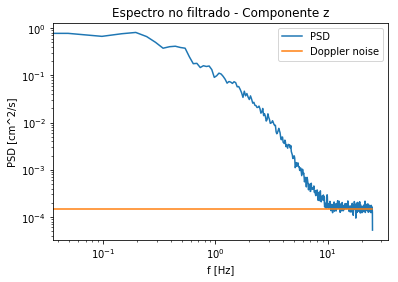

In [318]:
# Componente x
plt.figure(1)
plt.title('Espectro no filtrado - Componente x')
plt.ylabel('PSD [cm^2/s]')
plt.xlabel('f [Hz]')
plt.loglog(fx,psdx_unf)
plt.loglog(fx,noisex*np.ones(len(fx)))
plt.legend(['PSD','Doppler noise'])

# Componente y
plt.figure(2)
plt.title('Espectro no filtrado - Componente y')
plt.ylabel('PSD [cm^2/s]')
plt.xlabel('f [Hz]')
plt.loglog(fy,psdy_unf)
plt.loglog(fy,noisey*np.ones(len(fy)))
plt.legend(['PSD','Doppler noise'])

# Componente z
plt.figure(3)
plt.title('Espectro no filtrado - Componente z')
plt.ylabel('PSD [cm^2/s]')
plt.xlabel('f [Hz]')
plt.loglog(fz,psdz_unf)
plt.loglog(fz,noisez*np.ones(len(fz)))
plt.legend(['PSD','Doppler noise'])

### Cálculo de PSD filtrada

In [319]:
psdx = psdx_unf - noisex*np.ones(len(psdx_unf))
psdy = psdy_unf - noisey*np.ones(len(psdy_unf))
psdz = psdz_unf - noisez*np.ones(len(psdz_unf))

## Cálculo de estadísticos y cantidades turbulentas

### Valor medio

In [341]:
Vx = np.nanmean(Vx_raw)
Vy = np.nanmean(Vy_raw)
Vz = np.nanmean(Vz_raw)

display('Velocidad media dirección x (cm/s): '+str(Vx))
display('Velocidad media dirección y (cm/s): '+str(Vy))
display('Velocidad media dirección z (cm/s): '+str(Vz))

'Velocidad media dirección x (cm/s): 4.710994807961126'

'Velocidad media dirección y (cm/s): 3.6670029288424417'

'Velocidad media dirección z (cm/s): -0.1396042734473807'

### Fluctuaciones

In [342]:
vx = Vx_int-np.nanmean(Vx_int)
vy = Vy_int-np.nanmean(Vy_int)
vz = Vz_int-np.nanmean(Vz_int)

### Varianzas

In [343]:
# Sin corrección por ruido Doppler
varx_unc = np.nanvar(Vx_raw)
vary_unc = np.nanvar(Vy_raw)
varz_unc = np.nanvar(Vz_raw)

display('Varianza no corregida por ruido Doppler, dirección x (cm2/s2): '+str(varx_unc))
display('Varianza no corregida por ruido Doppler, dirección y (cm2/s2): '+str(vary_unc))
display('Varianza no corregida por ruido Doppler, dirección z (cm2/s2): '+str(varz_unc))

'Varianza no corregida por ruido Doppler, dirección x (cm2/s2): 0.4508336871859829'

'Varianza no corregida por ruido Doppler, dirección y (cm2/s2): 0.9144203758817234'

'Varianza no corregida por ruido Doppler, dirección z (cm2/s2): 0.4925726750586198'

In [344]:
# Corregidas por ruido Doppler
# Serie temporal
uu = vx*vx
vv = vy*vy
ww = vz*vz

# Varianzas medias
varx = varx_unc - noisex*fs/2
vary = vary_unc - noisey*fs/2
varz = varz_unc - noisez*fs/2

display('Varianza corregida por ruido Doppler, dirección x (cm2/s2): '+str(varx))
display('Varianza corregida por ruido Doppler, dirección y (cm2/s2): '+str(vary))
display('Varianza corregida por ruido Doppler, dirección z (cm2/s2): '+str(varz))

'Varianza corregida por ruido Doppler, dirección x (cm2/s2): 0.4466126079790574'

'Varianza corregida por ruido Doppler, dirección y (cm2/s2): 0.9099559137452784'

'Varianza corregida por ruido Doppler, dirección z (cm2/s2): 0.4924247899932213'

### Tensiones de Reynolds

In [345]:
# Serie temporal de tensiones de Reynolds
uv = vx*vy
uw = vx*vz
vw = vy*vz

# Tensiones de Reynolds medias
covaruv = np.mean(Vx_int*Vy_int)
covaruw = np.mean(Vx_int*Vz_int)
covarvw = np.mean(Vy_int*Vz_int)

display('Covarianza, direcciones xy (cm2/s2): ' + str(covaruv))
display('Covarianza, direcciones xz (cm2/s2): ' + str(covaruw))
display('Covarianza, direcciones yz (cm2/s2): ' + str(covarvw))

'Covarianza, direcciones xy (cm2/s2): 17.459278694653573'

'Covarianza, direcciones xz (cm2/s2): -0.6010829654342629'

'Covarianza, direcciones yz (cm2/s2): -0.45395120084831914'

### Energía cinética turbulenta

In [346]:
# Serie temporal de energía cinética turbulenta
tke = 0.5*(uu + vv + ww)

# Energía cinética turbulenta media
TKE = 0.5*(varx+vary+varz)

display('Energía cinética turbulenta (cm2/s2): ' + str(TKE))

'Energía cinética turbulenta (cm2/s2): 0.9244966558587785'

### Intensidad de turbulencia

In [347]:
Itx = np.sqrt(varx)/np.abs(Vx)
Ity = np.sqrt(vary)/np.abs(Vy)
Itz = np.sqrt(varz)/np.abs(Vz)
It = np.sqrt(1/3*(varx+vary+varz))/np.sqrt(Vx**2+Vy**2+Vz**2)

display('Intensidad de turbulencia, dirección x: ' + str(Itx))
display('Intensidad de turbulencia, dirección y: ' + str(Ity))
display('Intensidad de turbulencia, dirección z: ' + str(Itz))
display('Intensidad de turbulencia: ' + str(It))

'Intensidad de turbulencia, dirección x: 0.14185768360534556'

'Intensidad de turbulencia, dirección y: 0.260135078201867'

'Intensidad de turbulencia, dirección z: 5.0265642884376'

'Intensidad de turbulencia: 0.13146712126416976'

## Método Bootstrap para la determinación del tiempo óptimo de medición

Los tiempos de medición óptimos se determinan analizando la incertidumbre esperada en la estimación de los paramentos
turbulentos, sobre la base de series de velocidad de larga duración registradas en diversas localizaciones, las que a su vez serán sub-muestreadas con distintas duraciones. Para cada una de las sub-series conformadas se aplica la técnica de remuestreo MBB para estimar la incertidumbre de los siguientes parámetros:
1. Velocidades medias
2. Varianzas
3. Energía cinética turbulenta
4. Tensiones de Reynolds

En cada caso la técnica MBB se aplica con 1000 replicaciones. Sobre la base de los resultados proporcionados se calcularon los correspondientes coeficientes de variación, CV, definidos como la relación entre el error desvío estándar y el valor medio de cada parámetro.

In [326]:
# Definición de la función 'btsvar' de aplicación de la técnica MBB
def btsvar(a,Tblock,nboot): # a: señal de velocidad, Tblock: longitud del bloque, nboot: cantidad de repeticiones
    nblock = int(len(a)//(Tblock*fs))
    ac=np.copy(a[0:nblock*int(Tblock*fs)]) 
    b = ac.reshape(nblock,int(Tblock*fs))
    blockvar=np.array([])
    for i in range(0,nboot):
        c=np.array([])
        for j in range(0,int(len(a)//nblock)-1):
            c = np.append(c,b[random.randint(0,len(b)-1),:])            
            blockmean=np.append(blockvar,np.nanmean(c))
    return np.mean(blockmean), np.var(blockmean)

In [327]:
# Definición de la función 'bopt' para la determinación de la longitud de bloque óptimo
def bopt(vx,Tm): # vx: señal de velocidad, Tm: tiempo de medición
    acfunc = acf(vx-np.mean(vx), nlags=len(vx), fft=False, unbiased=True) # Función autocorrelación
    zero_crossings = np.where(np.diff(np.sign(c)))[0]
    Tx = np.trapz(acfunc[0:zero_crossings[0]],(1/fs)*range(zero_crossings[0])) # Escala de tiempo integral
    bop = 0.788 * Tx**(2/3) * Tm**(1/3)
    return bop

### Velocidades medias

In [336]:
# Aplicación de MBB para distintas duraciones
V = Vx_int # Señal de larga duración a evaluar
Ttot = (1/fs)*(len(V)-1)/60 # Tiempo total de medición, en minutos
Tm = np.linspace(1,int(Ttot),20) # Tiempos de medición considerados para el análisis, en minutos
vmean = np.zeros(len(Tm))
vvar = np.zeros(len(Tm))
cv = np.zeros(len(Tm))
bop = np.zeros(len(Tm))

for i in range(len(Tm)):
    vi = V[0:int(Tm[i]*60*fs)] # Sub-muestra del registro de velocidad
    vmean[i],vvar[i] = btsvar(vi,bopt(vi,Tm[i]),1000)
    bop[i] = bopt(vi,Tm[i])
    cv[i] = np.sqrt(vvar[i])/vmean[i]

Text(0,0.5,'Coeficiente de variación [-]')

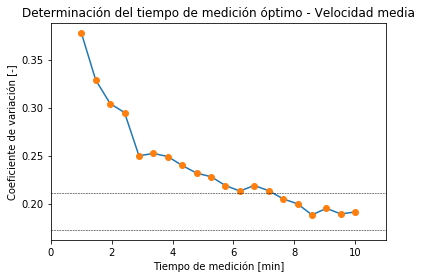

In [363]:
# Gráfico
plt.plot(Tm,cv)
plt.plot(Tm,cv,'o')
plt.plot([0, Tm[-1]*1.1],cv[-1]*1.1*np.ones(2),'k--',linewidth=0.5)
plt.plot([0, Tm[-1]*1.1],cv[-1]*0.9*np.ones(2),'k--',linewidth=0.5)
plt.xlim(0,Tm[-1]*1.1)
plt.title('Determinación del tiempo de medición óptimo - Velocidad media')
plt.xlabel('Tiempo de medición [min]')
plt.ylabel('Coeficiente de variación [-]')

### Varianzas

In [358]:
# Aplicación de MBB para distintas duraciones
V = vx # Señal de larga duración a evaluar
Ttot = (1/fs)*(len(V)-1)/60 # Tiempo total de medición, en minutos
Tm = np.linspace(1,int(Ttot),20) # Tiempos de medición considerados para el análisis, en minutos
vmean = np.zeros(len(Tm))
vvar = np.zeros(len(Tm))
cv = np.zeros(len(Tm))
bop = np.zeros(len(Tm))

for i in range(len(Tm)):
    vi = V[0:int(Tm[i]*60*fs)] # Sub-muestra del registro de velocidad
    vmean[i],vvar[i] = btsvar(vi,bopt(vi,Tm[i]),1000)
    bop[i] = bopt(vi,Tm[i])
    cv[i] = np.sqrt(vvar[i])/vmean[i]

Text(0,0.5,'Coeficiente de variación [-]')

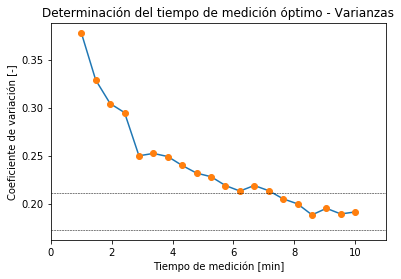

In [359]:
# Gráfico
plt.plot(Tm,cv)
plt.plot(Tm,cv,'o')
plt.plot([0, Tm[-1]*1.1],cv[-1]*1.1*np.ones(2),'k--',linewidth=0.5)
plt.plot([0, Tm[-1]*1.1],cv[-1]*0.9*np.ones(2),'k--',linewidth=0.5)
plt.xlim(0,Tm[-1]*1.1)
plt.title('Determinación del tiempo de medición óptimo - Varianzas')
plt.xlabel('Tiempo de medición [min]')
plt.ylabel('Coeficiente de variación [-]')

### Energía cinética turbulenta

In [351]:
# Aplicación de MBB para distintas duraciones
V = tke # Señal de larga duración a evaluar
Ttot = (1/fs)*(len(V)-1)/60 # Tiempo total de medición, en minutos
Tm = np.linspace(1,int(Ttot),20) # Tiempos de medición considerados para el análisis, en minutos
vmean = np.zeros(len(Tm))
vvar = np.zeros(len(Tm))
cv = np.zeros(len(Tm))
bop = np.zeros(len(Tm))

for i in range(len(Tm)):
    vi = V[0:int(Tm[i]*60*fs)] # Sub-muestra del registro de velocidad
    vmean[i],vvar[i] = btsvar(vi,bopt(vi,Tm[i]),1000)
    bop[i] = bopt(vi,Tm[i])
    cv[i] = np.sqrt(vvar[i])/vmean[i]

Text(0,0.5,'Coeficiente de variación [-]')

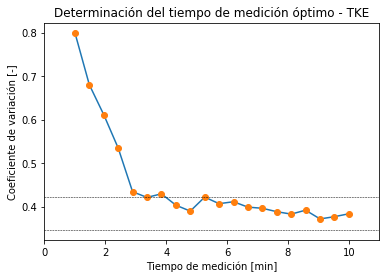

In [355]:
# Gráfico
plt.plot(Tm,cv)
plt.plot(Tm,cv,'o')
plt.plot([0, Tm[-1]*1.1],cv[-1]*1.1*np.ones(2),'k--',linewidth=0.5)
plt.plot([0, Tm[-1]*1.1],cv[-1]*0.9*np.ones(2),'k--',linewidth=0.5)
plt.xlim(0,Tm[-1]*1.1)
plt.title('Determinación del tiempo de medición óptimo - TKE')
plt.xlabel('Tiempo de medición [min]')
plt.ylabel('Coeficiente de variación [-]')

### Tensiones de Reynolds

In [356]:
# Aplicación de MBB para distintas duraciones
V = uv # Señal de larga duración a evaluar
Ttot = (1/fs)*(len(V)-1)/60 # Tiempo total de medición, en minutos
Tm = np.linspace(1,int(Ttot),20) # Tiempos de medición considerados para el análisis, en minutos
vmean = np.zeros(len(Tm))
vvar = np.zeros(len(Tm))
cv = np.zeros(len(Tm))
bop = np.zeros(len(Tm))

for i in range(len(Tm)):
    vi = V[0:int(Tm[i]*60*fs)] # Sub-muestra del registro de velocidad
    vmean[i],vvar[i] = btsvar(vi,bopt(vi,Tm[i]),1000)
    bop[i] = bopt(vi,Tm[i])
    cv[i] = np.sqrt(vvar[i])/vmean[i]

Text(0,0.5,'Coeficiente de variación [-]')

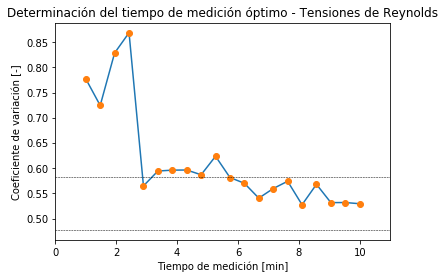

In [357]:
# Gráfico
plt.plot(Tm,cv)
plt.plot(Tm,cv,'o')
plt.plot([0, Tm[-1]*1.1],cv[-1]*1.1*np.ones(2),'k--',linewidth=0.5)
plt.plot([0, Tm[-1]*1.1],cv[-1]*0.9*np.ones(2),'k--',linewidth=0.5)
plt.xlim(0,Tm[-1]*1.1)
plt.title('Determinación del tiempo de medición óptimo - Tensiones de Reynolds')
plt.xlabel('Tiempo de medición [min]')
plt.ylabel('Coeficiente de variación [-]')

## Referencias

* García C.M., Scacchi G., Herrero H.S., Díaz Lozada J.M., Pedocchi F., Niño Y. y García M.H. (2016). "Guía práctica para realizar mediciones de velocidad en flujos turbulentos con ADV. Versión 2016". Extraído de: Scacchi G. (2017) "Interacción entre el flujo turbulento y los procesos de erosión junto a estribos de puentes protegidos. Estudio experimental"

* García C., Cantero M., Niño Y., and García M. (2005). “Turbulence measurements with Acoustic Doppler Velocimeters”. J.Hydr. Engrg. ASCE. 131, 1062-1073.

* García C. (). "Turbulence measurements using accoustic Doppler velocimeters".

* García C., Jackson P., and García M. (2006). “Confidence intervals in the determination of turbulence parameters”. Experiment in Fluids. 40: 514 – 522.

* Goring D., Nikora, V. (2002). "Despiking Acoustic Doppler Velocimeter Data". J. Hydr. Engrg. ASCE, Volume 128, (1), 117-126.

* Lemmin U., and Lhermitte R. (1999). “Discussion of ‘ADV measurements of turbulence: Can we improve their interpretation?’ by Nikora,V., and Goring, D.” J.Hydr. Engrg. ASCE. 125, 987-988.

* McLelland S. and Nicholas A. (2000). "A new method for evaluating errors in high frequency ADV measurements". Hydrological Processes. 14, 351-366.

* Nikora V., and Goring D. (1998). "ADV measuremets of turbulence: Can we improve their interpretation?" J.Hydr. Engrg. ASCE. 124, 630-634.

* Voulgaris G., and Trowbridge J. (1998). "Evaluation of the acoustic Doppler velocimeter (ADV) for turbulence measurements". Journal of Atmospheric and Oceanic Technology. 15, 272-288.